# Setup and Required Libraries

In [ ]:
pip install numpy pandas matplotlib yfinance scikit-learn tensorflow

# Fetching Real Stock Data Using Yahoo Finance

In [3]:
import yfinance as yf
import pandas as pd

# Download AAPL data from 2018 to 2024
data = yf.download('AAPL', start='2018-01-01', end='2025-12-31')
data = data[['Close']]
data.dropna(inplace=True)
print(data.tail())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close
Ticker            AAPL
Date                  
2025-04-15  202.139999
2025-04-16  194.270004
2025-04-17  196.979996
2025-04-21  193.160004
2025-04-22  199.740005


# Preprocessing Data for Transformer Input

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Reshape to include "features" dimension for Transformer
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], 1))


# Building a Custom Transformer Model in TensorFlow

In [11]:
import tensorflow as tf
from tensorflow.keras import layers

class Time2Vector(tf.keras.layers.Layer):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear', shape=(self.seq_len,), initializer='uniform', trainable=True)
        self.bias_linear = self.add_weight(name='bias_linear', shape=(self.seq_len,), initializer='uniform', trainable=True)
        self.weights_periodic = self.add_weight(name='weight_periodic', shape=(self.seq_len,), initializer='uniform', trainable=True)
        self.bias_periodic = self.add_weight(name='bias_periodic', shape=(self.seq_len,), initializer='uniform', trainable=True)

    def call(self, x):
        time_linear = self.weights_linear * x + self.bias_linear
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        return tf.concat([time_linear, time_periodic], axis=-1)

def build_transformer(seq_len):
    input_layer = layers.Input(shape=(seq_len, 1))
    time_embedding = Time2Vector(seq_len)(input_layer)

    x = layers.Concatenate()([input_layer, time_embedding])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)

    return tf.keras.Model(inputs=input_layer, outputs=x)


# Training the Transformer Model

In [16]:
import os
# 0 = all logs, 1 = INFO, 2 = WARNING, 3 = ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
# for TF2’s Python-side logger
tf.get_logger().setLevel('ERROR')

# import or build the rest of model
model = build_transformer(window_size)
model.compile(optimizer='adam', loss='mse')
model.summary()
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vector_1      │ (None, 60, 120)   │        240 │ input_layer_1[0]… │
│ (Time2Vector)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 60, 121)   │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ time2_vector_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 121)   │        242 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 121)   │     31,289 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 121)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 121)   │        242 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 121)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      7,808 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,886 (155.80 KB)

 Trainable params: 39,886 (155.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3567 - val_loss: 0.0633
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - val_loss: 0.0154
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0149
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0163
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - val_loss: 0.0120
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0108
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0076
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0135
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - val_loss: 0.0080
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - val_loss: 0.0075
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - val_l

# Making Predictions and Visualization

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


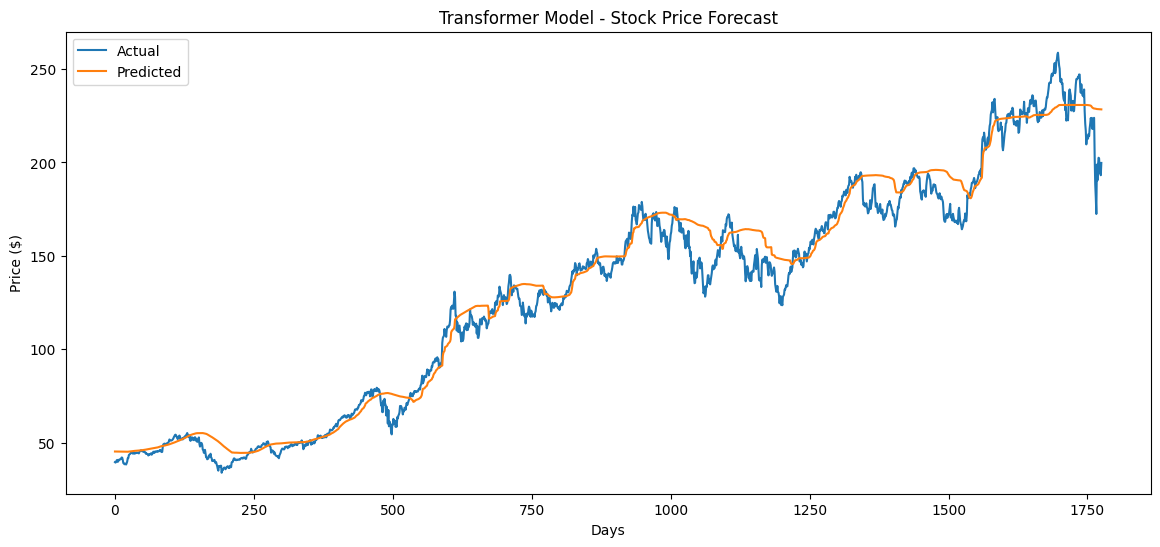

In [19]:
import matplotlib.pyplot as plt

predictions = model.predict(X)
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y)

plt.figure(figsize=(14, 6))
plt.plot(real_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.title('Transformer Model - Stock Price Forecast')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show()
